# Данилова Елизавета**


Датасет - https://www.kaggle.com/shrutimehta/zomato-restaurants-data


Данные о ресторанах из разных стран, с указанием рейтинга,услуг, ценовой категории, оценок посетителей, собраны данные при помощи zomato api, ресурса предоставляющего информацию о ресторанах всего мира

- Цель исследования данных : Выявить факторы влияющие на оценку рейтинга ресторанов и построить модель, предсказывающую высокий или низкий рейтинг заведений исходя из выявленных важных факторов.

**Общая логика работы состоит из**:  
- Выявления значимых переменных для анализа при помощи тестирования гипотез
- Построение моделей для предсказания рейтинга ресторанов и проверка их качества
- Построение модели дерева решения,для описания взаимосвязей в переменной "цена блюд", которая является значимой в моделях
- Построение ансамбля из моделей дерева решений и логистической регресии 
- Интерпретация модели ансамбля на конкретных примерах в данных

# Исследование гипотез, связанных с рейтингом ресторанов

In [ ]:
#загружаем библиотеки
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
%matplotlib inline

In [ ]:
rest = pd.read_excel("zomato.xlsx")

In [ ]:
rest = rest.drop(columns = ["Restaurant ID","Address","Locality","Locality Verbose","Longitude","Latitude","Aggregate rating"])
rest.columns = ['rest_name', 'country', 'city', 'cuisines', 'cost', 'curr','booking', 'delivery', 'deliveryNow','ordermenu',
             'price_range', 'rating_color', 'rating_text', 'votes']

rest.head()

In [ ]:
# удалим строки с пропущенными значениями
rest = rest.dropna()
len(rest)

9536

Исходя из данных меня заинтересовало сравнить влияние двух факторов(переменных) на рейтинг и ценовую политику заведения

1. Переменная(Has table booking?)
Влияет ли возможность бронирования столика на рейтинг ресторана и ценовую политику? (бронирование как показатель популярности ресторана и более клиентоориентированного отношения)
2. Влияет ли возможность заказать блюда с доставкой на рейтинг ресторана и ценовую политику? 


Для ответа на вопросы о рейтинге заведения используется chi-square test, который позволяет сравнивать две категориальные переменные


In [ ]:
rest_cut = rest[(rest.rating_text == "Average") | (rest.rating_text == "Excellent") |(rest.rating_text == "Good") | (rest.rating_text == "Poor")|(rest.rating_text == "Good") | (rest.rating_text == "Very Good")]


Создаем матрицы смежности для сравнения категорий, из них видно,что ресторанов без бронирования в данных больше, чем с бронированием. Однако в обоих случаях и с бронированием и с доставкой здесь нет пустых ячеек и слишком маленьких значений,поэтому можно запустить тесты

In [ ]:
t = pd.crosstab(rest_cut.rating_text, rest_cut.booking)
t

booking        No  Yes
rating_text           
Average      3338  394
Excellent     255   45
Good         1688  406
Poor          162   24
Very Good     836  242

In [ ]:
stats.chi2_contingency(t) 

(136.700179897884,
 1.4354237455394306e-28,
 4,
 array([[3170.93748309,  561.06251691],
        [ 254.8985115 ,   45.1014885 ],
        [1779.19161028,  314.80838972],
        [ 158.03707713,   27.96292287],
        [ 915.935318  ,  162.064682  ]]))

In [ ]:
m = pd.crosstab(rest_cut.rating_text, rest_cut.delivery)
m

delivery       No   Yes
rating_text            
Average      2627  1105
Excellent     261    39
Good         1277   817
Poor           70   116
Very Good     801   277

In [ ]:
stats.chi2_contingency(m) 


(205.88240971702106,
 2.0416933592838203e-43,
 4,
 array([[2543.21407307, 1188.78592693],
        [ 204.43843031,   95.56156969],
        [1426.98024357,  667.01975643],
        [ 126.75182679,   59.24817321],
        [ 734.61542625,  343.38457375]]))

Исходя из результатов тестов, в обоих случаях статистика показала очень низкий p-value, что говорит и статистически значимой разнице для представленных 

*Бронирование:*
- Для ресторанов с высоким рейтингом нет сильной разницы в возможности бронирования
-Однако для ресторанов с "очень хорошим" и "низким" рейтингов, показывает,что отсутствие бронирование характерно для ресторанов с таким рейтингом исходя из того что expected values выше реальных

*Доставка:*
- Для ресторанов с оценкой "Excellent" и "Very good" значительно ниже ожидаемые  значения,что может говорить о том,что рестораны сосредоточены на сервисе внутри ресторана,чем и зарабатывают свой высокий рейтинг
- У ресторанов же с "плохим" и "хорошим" рейтингом ожидаемые значения возможности доставки выше, что говорит о том,что рестораны с более низким рейтингом больше вовлечены в доставку


Дальше также была построена модель линейной регресии по переменным голосов,цены,бронирования и доставки. Модель показала, что ценовая категория ресторана зависит от выбранных категорий (facilities) бронирования и доставки. То есть предоставление дополнительных услуг т.е.клиентоориентированность важна для ресторанов с более высокой ценовой политикой и увеличивает их рейтинг.

Результаты модели схожи с результатами модели ниже, основывающейся уже на просто цене блюд в ресторане, показывающей схожие коэффициенты.

# **Предсказание рейтинга ресторана**


Предсказание рейтинга ресторана является в данном случая задачей классификации. Рейтинг ресторана упрощен до бинарной переменной - высокий или низкий, чтобы было удобнее строить модель логистической регресии и результаты можно было легче интерпретировать.

Для того,чтобы использовать переменную точных цен в заведении за одно посещение, были оставленны данные по одной стране, чтобы сравнивать цены в одной валюте.







### Предсказание рейтинга ресторана, методом классификации


Для решения заадачи классификации по определению рейтинга, т.е оценок ресторана посетителями, сначала будет использоваться метод деревьев решений, а затем модель логистической регрессии.


---
Ранее рассматривая эти данные было выявлено что восможности бронирования и доставки влияют на ценовую категорию ресторана и выражают некую зависимость от рейтинга заведения. Так,например, рестораны с очень высокими оценками,возможности бронирования и доставки не влияют на увеличение рейтинга,в то время как у ресторанов с хорошими или средне-плохим рейтингом часто прослеживается зависимость,что отсутствие бронирования влияет на оценки.


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
from sklearn import decomposition

Оставим переменные в данных по:
- бронированию
- доставке
- ценовой категории
- средней цене чека в заведении
- категориям рейтинга, которые будут преобразованы в бинарную переменную
- количеству оценок ресторана

In [ ]:
rest = pd.read_excel("zomato.xlsx")
rest = rest.drop(columns = ["Restaurant ID","Address","Locality","Locality Verbose","Longitude","Latitude","Aggregate rating"])
rest.columns = ['rest_name', 'country', 'city', 'cuisines', 'cost', 'curr','booking', 'delivery', 'deliveryNow','ordermenu',
             'price_range', 'rating_color', 'rating_text', 'votes']

rest_k = rest.drop(columns = ["rest_name","city","deliveryNow","rating_color","ordermenu","cuisines"])
rest_k.head()

Отфильтруем по самой многочисленной по наблюдениям в этом датасете стране - Индии

In [ ]:

rest_cut = rest_k[(rest_k.country == 1)]
rest_cut.head()


Преобразуем переменную рейтинг в бинарную. Заведения с высоким рейтингом, те которые имеют значения - Excellent, Very Good,Good,  значения с низким рейтингом - Average, Poor

In [ ]:
rest_cut.rating_text = rest_cut.rating_text.replace({"Excellent":'High', "Very Good":'High',"Good":'High',"Average":'Low',"Poor":'Low',"Not rated":'Other'})


In [ ]:
rest_cut = rest_cut[(rest_cut.rating_text == "High") | (rest_cut.rating_text == "Low")]
rest_cut.head()

In [ ]:
# удалим строки с пропущенными значениями 
rest_cut = rest_cut.dropna()
len(rest_cut)

6511

In [ ]:
# изменим тип переменной цены на числовой
rest_cut.cost=rest_cut.cost.apply(int)

In [ ]:
# Средняя цена в ресторанах Индии - 715 рупий,много заведений средней и низкой ценовой категории
rest_cut.describe()

cost  price_range         votes
count  6511.000000  6511.000000   6511.000000
mean    715.914606     1.882660    182.024113
std     647.092769     0.884441    485.133648
min       0.000000     1.000000      4.000000
25%     350.000000     1.000000     16.000000
50%     500.000000     2.000000     49.000000
75%     800.000000     2.000000    148.000000
max    8000.000000     4.000000  10934.000000

In [ ]:
rest_cut = rest_cut.drop(columns = ["curr","country"])


#### Построение модели дерева решений
После обработки данных, построим дерево решений, предсказывающее высокий или низкий рейтинг заведения,по выбранным переменным,исключая переменную price-range, так как она будет коррелировать с переменной cost.

In [ ]:
y = rest_cut.rating_text

In [ ]:
X = rest_cut.drop(columns=["rating_text", "price_range"])

In [ ]:
X = pd.get_dummies(X, drop_first=True)
X.head()

In [ ]:
# Разделим данные на тренировочную и тестовую выборку
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

treeC = DecisionTreeClassifier(max_depth = 3)
treeC.fit(X_train,y_train)
treeC.score(X_train, y_train), treeC.score(X_test, y_test)

(0.7940092165898618, 0.7968678028558268)

---
Значения score  на тренировочной выборке близки к 0.8, что достаточно хорошо для классификации рейтинга по ограниченному количеству переменных. Показания на тестовой выборке немного больше, что показывает достаточно хорошую точность модели дерева.



Точность модели


In [ ]:
tree_pred = treeC.predict(X_test)

In [ ]:
from sklearn import metrics
metrics.accuracy_score(y_test, tree_pred)

0.7968678028558268

Матрица смежности, f1 ratio

In [ ]:
metrics.confusion_matrix(y_test, tree_pred)

array([[ 665,  225],
       [ 216, 1065]])

In [ ]:
metrics.f1_score(y_test, tree_pred, pos_label = "High")

0.7509881422924902

In [ ]:
metrics.f1_score(y_test, tree_pred, pos_label = "Low")

0.8284714119019838

Смотря на правильно и не правильно предсказанные значения, значения f1 ration объединяющего показания precision & recall выше, можно сказать что модель лучше предсказывает низкий рейтинг у ресторанов. Возможно потому,что плохие показатели votes и цены легче отделить и потому,что в группу с хорошими ресторанами входит больше ктгорий рейтинга

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


Визуализируем дерево и посмотрим на разбиения,чтобы выявить логику предсказания рейтинга нашей моделью

In [ ]:
y.unique()

array(['High', 'Low'], dtype=object)

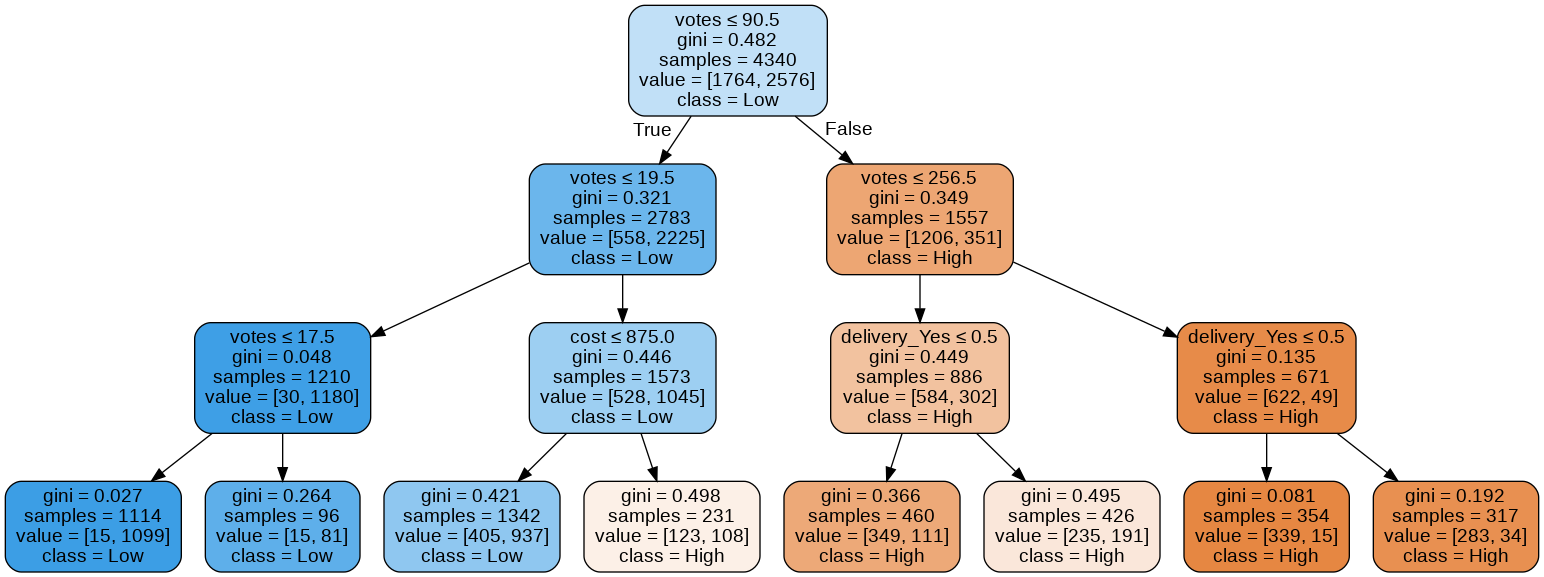

In [ ]:
dot_data = StringIO()
export_graphviz(treeC, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names = X.columns,
                class_names=["High", "Low"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Выводы по дереву:
- Разбиение в категорию низкого рейтинга происходит более четко, самая выделяющаяся группа по разбиению [15,1099] как раз относится к низкому рейтингу
- Группы с низким рейтингом хорошо выделяются по показателю оценок заведения, так заведения с оценками меньше 19,5 согласно дереву решения относятся к низкому рейтингу, однако чем выше значение votes, тем больше ошибок
-Однако,даже заведения с низкими оценками,но более высоким прайсом,определяются в категорию высокого рейтинга, но с высокой ошибкой определения. Это можно назвать пограничными случаями,где, например, достаточно новый ресторан с малых количеством оценок, имеет хорошие отзывы по рейтингу и прайс выше среднего,что говорит,о более высоком качестве блюд
- Для определения высокого рейтинга, в модели появилась категория разбиения - возможность онлайн доставки. Получается,что при разбиении для ветки высокого рейтинга модель обращает внимание уже на дополнительные услуги ресторана. Так,например, если значение отзывов о ресторане меньше 256,но имеется возможность доставки, то ресторан с большей вероятностью будет иметь высокий рейтинг. Для ресторанов уже итак с большим количеством оценок, доставка тоже выделяется в качестве разбиения,но уже не так сильно влияет на определение рейтинга.


#### Логистическая регрессия 

Построим модель предсказания рейтинга ресторана, используя те же переменные, чтобы посмотреть степень значимости отдельных факторов.

In [ ]:
import statsmodels.formula.api as smf
rest_num = pd.get_dummies(rest_cut, columns = ["rating_text", "booking", "delivery"] )
model= smf.logit(formula="rating_text_High ~ cost + votes + delivery_Yes + booking_Yes", data= rest_num).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.491589
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       rating_text_High   No. Observations:                 6511
Model:                          Logit   Df Residuals:                     6506
Method:                           MLE   Df Model:                            4
Date:                Wed, 23 Dec 2020   Pseudo R-squ.:                  0.2728
Time:                        12:01:04   Log-Likelihood:                -3200.7
converged:                       True   LL-Null:                       -4401.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.9552      0.061    -32.221      0.000      -2.074      -1.836
cost             0.0008   7.45e-05     10.333      0.000       0.001       0.001
votes            0.0107      0.000     26.696      0.000       0.010       0.011
delivery_Yes     0.1070      0.065      1.659      0.097      -0.019       0.233
booking_Yes     -0.6687      0.115     -5.822      0.000      -0.894      -0.444
================================================================================
"""

In [ ]:
model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
model_odds['p-value']= model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())
model_odds

OR        p-value      2.5%     97.5%
Intercept     0.141531  8.996354e-228  0.125661  0.159406
cost          1.000770   5.011878e-25  1.000624  1.000916
votes         1.010717  5.237403e-157  1.009926  1.011508
delivery_Yes  1.112957   9.720772e-02  0.980738  1.263002
booking_Yes   0.512369   5.800970e-09  0.409092  0.641718


Смотря на коэффициенты переменных и odds ratio можно понять, что:
- коэффициенты возможности доставки статистически не значимы в модели
- Увеличение значения цены и количества оценок увеличивают шансы на определение ресторана к категории высокого рейтинга
- odds ratio у бронирования меньше единицы, что показывает уменьшение шансов на высокий рейтинг,при наличии возможности бронирования. Эта закономерность проявлялась и при предыдущем анализе,подразумевая под собой что рестораны с высоким рейтингом и ценовой категорией меньше предоставляют возможности бронирования и этот показатель не влияет на рейтинг таких заведений,а является индикатором ресторанов с более низким рейтингом

Точность предсказания модели

In [ ]:
from sklearn.linear_model import LogisticRegression
logC = LogisticRegression()
logC.fit(X_train,y_train)
logC.score(X_train, y_train), logC.score(X_test, y_test)

(0.7790322580645161, 0.7669276830953478)

In [ ]:
y_predlog = logC.predict(X_test)
y_predlog

array(['Low', 'High', 'Low', ..., 'Low', 'Low', 'Low'], dtype=object)

In [ ]:
metrics.confusion_matrix(y_test, y_predlog)

array([[ 489,  401],
       [ 105, 1176]])

In [ ]:
print(metrics.roc_auc_score(y_test == "High", y_predlog == "High"))

0.7337354945662183


Точность предсказания модели ниже,чем у дерева решений, но результаты на тестовой выборке чуть ниже,чем на обучающей, тем самым можно сказать,что модель не переобучена

Модель логистической регрессии хуже определяет по группам рестораны с высоким рейтингом,чем модель дерева решений,что видно из матрицы смежности.

Roc Auc Curve имеет значение 0.73, что показывает неплохую точность модели по объясняемости данных, так как показатель явно больше 0.5 мы можем судить о неслучайном распределении в модели и то, что она достаточно неплохо категоризирует рестораны по рейтингу.

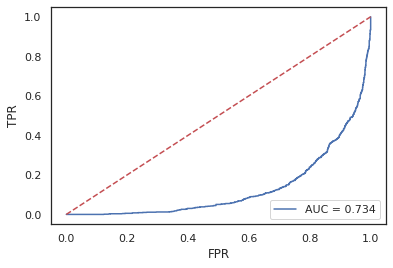

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test == "High", logC.predict(X_test)== "High")
fpr, tpr, thresholds = roc_curve(y_test == "High", logC.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='AUC = %0.3f' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")

# Построение и интерпретация ансамбля моделей(Gradient boosting & lime)
Так как обе модели и регрессия и дерево показали достаточно хорошие результаты предсказания рейтинга,но немного разнились по влияниюю переменных, то можно попробовать совместить две эти модели в один ансамбль для улучшения качества модели и более точной интерпретации результатов предсказания.

In [ ]:
# делаем dummy variables
rest_cut = rest_cut[['cost', 'booking', 'delivery', 'price_range', 'votes',"rating_text"]]

rest_cut = rest_cut.drop(columns = ["price_range"])
rest_cut.head()

cost booking delivery  votes rating_text
622   850      No       No  140.0        High
623   700      No       No   71.0        High
624   500      No       No   94.0        High
625   400      No       No   87.0        High
626  1000      No       No  177.0        High

In [ ]:
rest_num = pd.get_dummies(rest_cut, columns = ["booking", "delivery","rating_text"])

In [ ]:
rest_num = rest_num.drop(columns = ["booking_No","delivery_No","rating_text_Low"])

Отфильтруем по votes, так как есть выпады больших значений, которые мешают интерпретации

In [ ]:
rest_num = rest_num[(rest_num.votes <= 600)]

In [ ]:
rest_num.head()

cost  votes  booking_Yes  delivery_Yes  rating_text_High
622   850  140.0            0             0                 1
623   700   71.0            0             0                 1
624   500   94.0            0             0                 1
625   400   87.0            0             0                 1
626  1000  177.0            0             0                 1

In [ ]:
names = ['cost', 'votes', 'booking_Yes', 'delivery_Yes', 'rating_text_High']

Разбиваем на тестовую и обучающую выборку


In [ ]:
X = rest_num.iloc[:, 0:4].values
y = rest_num.iloc[:,4].values

In [ ]:
# тестовая - обучающая
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

Строим модели регресии и дерева решений


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# логистическая регрессия
logreg = LogisticRegression(solver = "liblinear")
logreg.fit(X_train, y_train)
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.7680374292046294, 0.7769571639586411)

In [ ]:
# дерево
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 3)
tree.fit(X_train, y_train)
tree.score(X_train, y_train), tree.score(X_test, y_test)

(0.7791184437330707, 0.7754800590841949)

Точность у модели дерева немного лучше на обучающей выборке, но на тестовой выборке у обеих моделей различия минимальны. Теперь построим ансамбли.

## Построение ансамблей
В целом на этих данных было построено около 5 разных моделей ансамблей,но для итогового проекта были оставлены модели,показывающие наибольшую точность предсказания,которая выше показатель точности исходных моделей в ансамбле. Так для интерпретации были оставлены модели случайного леса и градиентного бустинга

In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4)
modelRF.fit(X_train, y_train)
modelRF.score(X_train, y_train), modelRF.score(X_test, y_test)

(0.7943856193055897, 0.7912358444116199)

In [ ]:
# boosting: gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
modelGB = GradientBoostingClassifier(n_estimators=100)
modelGB.fit(X_train, y_train)
modelGB.score(X_train, y_train), modelGB.score(X_test, y_test)

(0.8089140605762127, 0.7971442639094042)

Лучше всего по точности работают модели, основанные на деревьях решений, random forest & gradient boosting. Думаю, что частично деревья лучше справляются, так как стоит задача классификации данных, в данном случае ресторанов с высоким и низким рейтингом.

## Интерпретация моделей



### Feature importance


In [ ]:
!pip install eli5

Посмотрим на значимые переменные в модели дерева, на первом месте находится votes, который забирает на себя большую долю веса в интерпретации модели, на втором месте идет доставка,а остальные переменные не имеют веса, что выглядит достаточно странно. Нужно посмотреть на значения веса переменных в лучших по качеству ансамблях дальше.

In [ ]:
import eli5
feat_imp_tree = eli5.explain_weights_df(tree, feature_names=names[0:4])
feat_imp_tree

feature    weight
0         votes  0.975375
1  delivery_Yes  0.024625
2   booking_Yes  0.000000
3          cost  0.000000

В моделях random forest & gradient boosting доля веса переменной "оценок ресторана" падает и начинает распределяться по другим переменным .Таким образом, на второе место выходит цена на блюда в заведениях. Доля переменной "доставки" немного меньше и примерно одинакова по двум моделям,однако бронирование немного значимей влияет в модели градиентного бустинга.

In [ ]:
eli5.explain_weights_df(modelGB, feature_names=names[0:4])

feature    weight       std
0         votes  0.881061  0.260915
1          cost  0.077725  0.227036
2  delivery_Yes  0.024550  0.068488
3   booking_Yes  0.016663  0.114272

In [ ]:
eli5.explain_weights_df(modelRF, feature_names=names[0:4])

feature    weight       std
0         votes  0.931494  0.014418
1          cost  0.040471  0.014336
2  delivery_Yes  0.024475  0.010699
3   booking_Yes  0.003560  0.005049

### Mean Decrease Accuracy (MDA)

In [ ]:

from eli5.sklearn import PermutationImportance
permGB = PermutationImportance(modelGB).fit(X_test, y_test)
eli5.explain_weights_df(permGB, feature_names=names[0:4])

feature    weight       std
0         votes  0.232201  0.014204
1          cost  0.037322  0.005092
2   booking_Yes  0.002462  0.004012
3  delivery_Yes  0.000788  0.001269

In [ ]:
eli5.show_weights(permGB, feature_names=names[0:4])

In [ ]:
permRF = PermutationImportance(modelRF).fit(X_test, y_test)
eli5.show_weights(permRF, feature_names=names[0:4])

Если смотреть на MDA, то есть показания уменьшения значимости отдельных переменных в модели,то модель бустинга показывает меньшую значимость переменной доставки, а модель случайного леса наоборот, также модель градиентного бустинга немного в большей степени уделяет значение весу переменной cost.

## Lime interpretation

In [ ]:
!pip install lime

In [ ]:
# библиотека от авторов метода
import lime
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
explainer = LimeTabularExplainer(X_train, mode='classification', 
                                 feature_names=names[0:4]) 

Посмотрим на объяснения отдельных примеров из данных с помощью модели gradient boosting,так как это модель показала лучшие показатели точности для решения выбранной задачи предсказания рейтинга

1 пример

In [ ]:

exp = explainer.explain_instance(X_test[11,:], 
                                 modelGB.predict_proba)

Объяснение

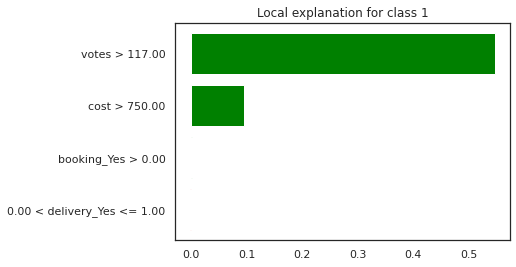

In [ ]:
exp.as_pyplot_figure();

In [ ]:
exp.show_in_notebook()

Высокие значения количества оценок и достаточно высокие цены в ресторане повышают вероятность определения ресторана к хорошему рейтингу, в то время как наличие бронирования влияет на вероятность определения ресторана к плохому рейтингу

2 пример

In [ ]:
exp = explainer.explain_instance(X_test[394,:], 
                                 modelGB.predict_proba)

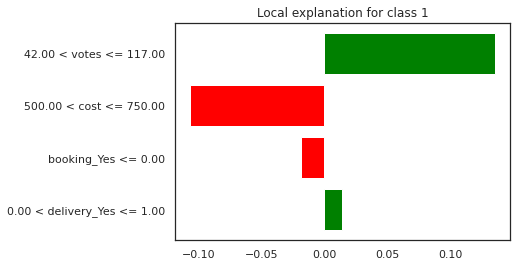

In [ ]:
exp.as_pyplot_figure();

In [ ]:
exp.show_in_notebook()

Второй пример показывает случай, где модель работает неочевидно и непонятно, т.к, при средних значениях votes их влияние относится к положительному рейтингу, но больше влияние и вероятность в 0.67 к плохому рейтингу дает стоимость блюд в заведении,стоимость здесь представлена в промежутке ниже среднего по данным.

3 пример

In [ ]:
exp = explainer.explain_instance(X_test[48,:], 
                                 modelGB.predict_proba)

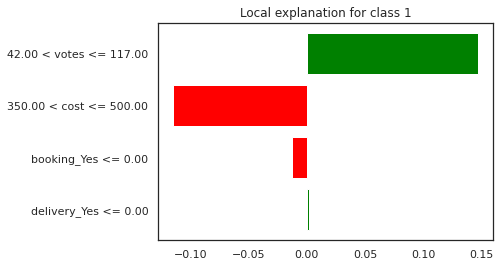

In [ ]:
exp.as_pyplot_figure();

In [ ]:
exp.show_in_notebook()

В данных много чисто закономерных примеров где низкие значения оценок относятся к никому рейтингу,а высокие к высокому. Но вот на этом примере можно увидеть опять значимость переменной цены и недоступности бронирования на определение низкого рейтинга

Таким образом модели ансамблей интерпретируются похожим образом, что и обычные модели регрессий и деревьев.Из анализа стало ясно, что самой важной переменной для интерпретации является количество оценок ресторана, однако для разных уникальных случаев также важны и закономерности в переменных цены, доставки и бронирования,но в значительно меньшей доле.


# Выводы

Из практических выводов для потенциального заказчика подобного анализа можно отметить, что:
- возможность доставки заказа онлайн и бронирования столика, как дополнительные услуги, помогают улучшить рейтинг и популярность заведений в средней ценовой категории
-более элитные рестораны с высокими ценниками и обслуживанием тоже выигрывают от введения дополнительных сервисных услуг, однако часто отсутствие возможности бронирования является признаком ресторанов с более высокими ценами и рейтингом. Это можно объяснить тем,что в данном случае на рейтинг данных заведений не влияет возможность бронирования. Также, возможно,что у данных заведений нет надобности в услугах бронирования из-за большого спроса на услуги или наоборот это немноголюдные рестораны с высоким классом обслуживания
- На рейтинг заведения сильно влияет именно количество оценок заведения, если количество оценок высокое, то больше вероятность, что у данного ресторана хороший рейтинг. В то время как у ресторанов с низкими оценками, для получения более высого рейтига необходимо наличие дополнительного сервиса или качества блюд,которое можно проследить через ценовую политику заведения.